# **Requirements and imports**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from imutils import paths
import argparse
import cv2
import os

import time

import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from tqdm.keras import TqdmCallback

# **Model definition/setup**

In [4]:
data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
    ])

def create_model(data_augmentation=None, l2_reg_factor= 0.001, dropout=0.3):
  #with tf.device("/gpu:0"):
  l2_regularizer = tf.keras.regularizers.l2(l2_reg_factor)

  image_1_input = tf.keras.Input(shape=(image_size[0], image_size[1], 3), name='image_1_input')
  image_2_input = tf.keras.Input(shape=(image_size[0], image_size[1], 3), name='image_2_input')

  # Rescale
  X1 = tf.keras.applications.mobilenet.preprocess_input(image_1_input)
  X2 = tf.keras.applications.mobilenet.preprocess_input(image_2_input)

  # If we want built in data augmentation
  if data_augmentation != None:
    X1 = data_augmentation(X1)
    X2 = data_augmentation(X2)

  # One convolutional layer
  X1 = layers.Conv2D(3, kernel_size=(5, 5), padding='same', kernel_regularizer = l2_regularizer)(X1)
  X2 = layers.Conv2D(3, kernel_size=(5, 5), padding='same', kernel_regularizer = l2_regularizer)(X2)
  
  #activation
  X1 = layers.ReLU()(X1)
  X2 = layers.ReLU()(X2)

  #batch normalization to regularize training
  #X1 = layers.BatchNormalization()(X1)
  #X2 = layers.BatchNormalization()(X2)

  #dropout
  X1 = layers.Dropout(dropout)(X1)
  X2 = layers.Dropout(dropout)(X2)

  # Max pooling layer
  X1 = layers.MaxPooling2D()(X1)
  X2 = layers.MaxPooling2D()(X2)
  
  pretrained_model1 = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

  pretrained_model1.trainable=True #
  #pretrained_model2.trainable=False

  X1 = pretrained_model1(X1)
  X2 = pretrained_model1(X2)

  # Flattening
  X1 = tf.keras.layers.GlobalAveragePooling2D()(X1)
  X2 = tf.keras.layers.GlobalAveragePooling2D()(X2)
  
  X = layers.Concatenate(axis=1)([X1, X2])

  # # First dense
   #X = layers.Dense(512, kernel_regularizer = l2_regularizer)(X)
   #X = layers.ReLU()(X)
  # #X = layers.BatchNormalization()(X)
   #X = layers.Dropout(dropout)(X)
  
  # #second dense
   #X = layers.Dense(256, kernel_regularizer = l2_regularizer)(X)
   #X = layers.ReLU()(X)
  # #X = layers.BatchNormalization()(X)
   #X = layers.Dropout(dropout)(X)

  #second dense
  X = layers.Dense(64, kernel_regularizer = l2_regularizer)(X)
  #X = layers.ReLU()(X)
  #X = layers.BatchNormalization()(X)
  X = layers.Dropout(dropout)(X)

  # Output
  outputs = layers.Dense(1)(X)

  model = tf.keras.Model(inputs=[image_1_input, image_2_input], outputs=outputs)
  return model

In [12]:
def get_compiled_model(data_augmentation= None, l2_reg_factor= 0.001, dropout=0.3, lrate=0.005):
      loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
      model = create_model(data_augmentation, l2_reg_factor, dropout)
      optimizer = tf.keras.optimizers.SGD(learning_rate=lrate)
      model.compile(optimizer = optimizer,
                    loss=loss_object,
                    metrics = [tf.keras.metrics.BinaryAccuracy(threshold=.0)])
      return model
      
def make_or_restore_model(infolder, data_augmentation= None, l2_reg_factor= 0.001, dropout=0.3, lrate=0.005):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [os.path.join(infolder, name) for name in os.listdir(infolder)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getmtime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint)    
    else:
      print("Creating a new model")
      return get_compiled_model(data_augmentation, l2_reg_factor, dropout, lrate=lrate)

# Classification Data Testing

In [15]:
save_folder = 'Land Application Data/model_weights/dual_cnn/'
model = make_or_restore_model(save_folder, l2_reg_factor=0, dropout=0.5)

Restoring from /gdrive/Shareddrives/land-app-public/model_weights/dual_cnn/best_model


In [19]:
labels = os.listdir('Land Application Data/training_data/labels')
labels = [l.split('.')[0] for l in labels]
image_path = '/gdrive/Shareddrives/land-app-public/test_data/classification_test/images'
images = os.listdir(image_path)

In [20]:
loc_dict = {}
for image in images:
  loc = image.split('_')[1]
  if loc in loc_dict:
    loc_dict[loc].append(image)
    loc_dict[loc] = sorted(loc_dict[loc])
  else:
    loc_dict[loc] = [image]

In [21]:
from sklearn.metrics import precision_recall_curve, auc
image_size = (512, 512)
img_height = image_size[1]
img_width = image_size[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])
def load_img(file_path):
  #label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

precs = []
recs = []
scores_list = []
actual_list = []

for loc in tqdm(loc_dict):
  images = loc_dict[loc]
  for i in range(1, len(images)):
    img0 = images[i-1]
    img1 = images[i]
    if img1.split('.')[0] in labels:
      y =[1]
    else:
      y= [0]

    x0 = load_img(os.path.join(image_path, img0))
    x1 = load_img(os.path.join(image_path, img1))
    
    
    output = model((x0[np.newaxis, ...], x1[np.newaxis,...]), training=False)

    output= tf.math.sigmoid(output)
    actual_list += y
    scores_list += list(output.numpy())

p,r,_ = precision_recall_curve(actual_list, scores_list)
precs.append(p)
recs.append(r)

  0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
results_path = './'
if not os.path.exists(results_path):
  os.mkdir(results_path)
np.save(results_path+'precisions.npy', precs[0])
np.save(results_path+'recalls.npy', recs[0])
np.save(results_path+'scores.npy', np.asarray(scores_list))
np.save(results_path+'labels.npy', np.asarray(actual_list))

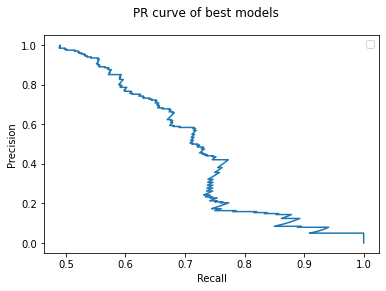

In [23]:
#PR curves at epoch 75
fig, ax = plt.subplots(1,1)

name = 'single_image_model4_0.5drop_filtering'
#auc = auc(p, r)
ax.plot(p, r,)# label='{}, auc {:.3f}'.format(name, auc))


ax.legend()
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
fig.suptitle("PR curve of best models")
fig.show()